##Importações

pip install unicodedata
pip install json
pip install requests
pip install datetime
pip install numpy
pip install matplotlib
pip install python -m pip install TA_Lib-0.4.24-cp39-cp39-win_amd64.whl
pip install plotly
pip install pandas_datareader
pip install pandas
pip install yfinance
pip install statsmodels
pip install nbformat
pip install pantas_ta

In [1]:
# Usar python 3.9 e TA_Lib-0.4.24-cp39-cp39-win_amd64.whl
# from binance.client import Clientcommand:workbench.trust.manage
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import time
import integration
import wallet_controller as wallet
import utils
import indicators
import send_email

matplotlib.style.use('ggplot')



In [2]:
#btc_price = get_price_coin_range('btc', int(datetime.datetime(2013, 1, 21).timestamp()), int(datetime.datetime(2023, 11, 7).timestamp())) # Ano, mês, dia
btc_price_ohlc = integration.get_price_coin_ohlc('btc')
btc_price_ohlc = btc_price_ohlc[~btc_price_ohlc.index.duplicated(keep='first')]

""" eth_price_ohlc = get_price_coin_ohlc('eth')
eth_price_ohlc = eth_price_ohlc[~eth_price_ohlc.index.duplicated(keep='first')] """

btc_price_complete = integration.get_price_coin_range('btc', int(datetime.datetime(2013, 1, 1).timestamp()), int(time.time())) # Ano, mês, dia
btc_price_complete = btc_price_complete[~btc_price_complete.index.duplicated(keep='first')]


In [3]:
def plot_grafico(month, corte, thread):
    
    df_invest = utils.slice_per_month(btc_price_complete.copy(), month, corte)
        
    df_invest_rsi = utils.slice_per_month(indicators.create_rsi_indicator(btc_price_complete.copy(), 2), month, corte)
    df_invest_lines = indicators.calculate_supports_lines(utils.slice_per_month(btc_price_ohlc.copy(), month, corte), 1)
    
    """ df_invest_trend = indicators.create_trend_indicator(btc_price_complete.copy(), 3)
    fig, ax = plt.subplots(figsize=(30, 6))
    df_invest['close'].plot(ax=ax, title="Análises")
    # Defina os limites do eixo Y com algum espaço acima e abaixo dos valores reais para garantir que o eixo seja visível
    y_min, y_max = df_invest_rsi['close'].min()*-2, df_invest_rsi['close'].max()*2
    ax.set_ylim(y_min, y_max)
            
    # Adicione linhas verticais em verde para 'bulls'
    for bull_date in df_invest_trend['bulls']:
        ax.axvline(x=bull_date, color='green', linestyle=':')

    # Adicione linhas verticais em vermelho para 'bears'
    for bear_date in df_invest_trend['bears']:
        ax.axvline(x=bear_date, color='red', linestyle=':')

    # Desenhe as linhas de suporte e resistência
    for level in df_invest_lines['support']:
        ax.axhline(y=level, color='green', linestyle='--')

    for level in df_invest_lines['resistence']:
        ax.axhline(y=level, color='red', linestyle='--') """

    for rsi in df_invest_rsi.index:
        if rsi in df_invest.index:
            #if df_invest_rsi['rsi_indicator'][rsi] == 'compra':
            if df_invest_rsi['rsi_indicator'][rsi] == 'compra' and (df_invest['close'][rsi] <= df_invest_lines['support'][0]):
                #ax.scatter(rsi, df_invest['close'][rsi], color='green', marker='^', label='Compra')
                wallet.calcular_informacoes_operacao("BTC", str(rsi)[:10], "0.001", str(df_invest['close'][rsi]), "buy", thread)
                #return 0.01
            #if df_invest_rsi['rsi_indicator'][rsi] == 'venda':
            if df_invest_rsi['rsi_indicator'][rsi] == 'venda' and (df_invest['close'][rsi] >= df_invest_lines['resistence'][0]):
                #ax.scatter(rsi, df_invest['close'][rsi], color='red', marker='v', label='Venda')
                wallet.calcular_informacoes_operacao("BTC", str(rsi)[:10], "0.0001", str(df_invest['close'][rsi]), "sell", thread)
                #return 0
    """ # Exiba a legenda apenas uma vez após os loops
    ax.legend(['Close', 'Bull Date', 'Bear Date', 'Suporte', 'Resistência', 'Compra RSI', 'Venda RSI'])
    
    # Mostrar o gráfico
    plt.savefig(utils.path + 'grafico.png')
    plt.show() """
    
    #wallet.calcular_informacoes_operacao("BTC", "2023-11-11", "0.0059", "36642", "buy")    
#plot_grafico(60, -365, 321)
""" for i in range(5, 1, -1):
    plot_grafico(i, 81, 'aaaj') """
""" for i in range(106, 1, -1):
    plot_grafico(i, 321, 'z') """

#plot_grafico(2, 30, "aaay")
#plot_grafico(4, 100, "aaax")

#plot_grafico(4, 81, "aaaj")
#plot_grafico(110, 60, "aaax")

" for i in range(106, 1, -1):\n    plot_grafico(i, 321, 'z') "

In [4]:
def validar_resultados_wallet(month, slice, wallet):
    thread = wallet
    plot_grafico(month, slice, thread)
    carteira = utils.ler_carteira_json(thread)
    dolar = 4.9
    valor_comprado = sum(float(item['amount']) for item in carteira['BTC'] if item['operation'] == 'buy')
    json_resultados = {
        "meses": month,
        "corte": slice,
        "BTCs_comprados": valor_comprado,
        "btc_dolar_hoje": float(carteira['BTC'][-1]['amount_total']) * btc_price_complete['close'][-1],
        "dolares_gastos": float(carteira['BTC'][-1]['wallet_usd'])
    }
    json_resultados['resultado'] = json_resultados['dolares_gastos'] + json_resultados['btc_dolar_hoje']
    print(json.dumps(json_resultados))
    utils.gravar_resultados_json(json_resultados)
#validar_resultados_wallet(2, 10, "aaax")
#validar_resultados_wallet(39, 364, "aaay")

In [16]:
import concurrent.futures
import threading
import time
import itertools
resultados = []
results_temp = {}
contadores = {}
def validar_resultados_wallet(args):
    month, slice = args
    thread = threading.current_thread().ident
    thread = f'{slice}'
    json_resultados = {}
    #utils.gravar_carteira_json({}, thread)
    plot_grafico(month, slice, thread)
    carteira = utils.ler_carteira_json(thread)
    dolar = 4.9
    valor_comprado = sum(float(item['amount']) for item in carteira['BTC'] if item['operation'] == 'buy')
    valor_vendido = sum(float(item['amount']) for item in carteira['BTC'] if item['operation'] == 'sell')
    json_resultados = {
        "meses": month,
        "corte": slice,
        "BTCs_comprados": valor_comprado,
        "BTCs_vendidos": valor_vendido,
        "btc_dolar_hoje": float(carteira['BTC'][-1]['amount_total']) * utils.slice_per_month(btc_price_complete['close'], month, slice)[-1],
        "dolares_gastos": float(carteira['BTC'][-1]['wallet_usd'])
    }
    json_resultados['resultado'] = json_resultados['dolares_gastos'] + json_resultados['btc_dolar_hoje']
    json_resultados['porcentagem'] = round(((json_resultados["btc_dolar_hoje"] + json_resultados["resultado"]) / json_resultados["btc_dolar_hoje"] -1)* 100, 2)
    print(json.dumps(json_resultados))
    if thread in results_temp:
        results_temp[thread].append(json_resultados)
    else:
        results_temp[thread] = []
        results_temp[thread].append(json_resultados)
    
    if thread in contadores:
        contadores[thread] += 1
    else:
        contadores[thread] = 1
    if contadores[thread] == 1:
        resultados.append(results_temp[thread][0])
        contadores[thread] = 0
        results_temp[thread] = []

#validar_resultados_wallet(4, 1460, 300)
# Defina suas faixas
slice_range = range(1, 365)
slice_range = [81]

months_range = [81]
months_range = range(80, 1, -1)
# Crie todas as combinações possíveis
combinations = list(itertools.product(months_range, slice_range))

#print(combinations)
# Número de threads a serem utilizadas
num_threads = 1

# Use ThreadPoolExecutor para executar a função em várias threads
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Mapeie a função diretamente para a lista de combinações
    executor.map(validar_resultados_wallet, combinations)
utils.gravar_resultados_json(resultados)
print(resultados)

{"meses": 79, "corte": 81, "BTCs_comprados": 0.001, "BTCs_vendidos": 0, "btc_dolar_hoje": 2.27462, "dolares_gastos": -2.03329, "resultado": 0.24133000000000004, "porcentagem": 10.61}
{"meses": 78, "corte": 81, "BTCs_comprados": 0.001, "BTCs_vendidos": 0, "btc_dolar_hoje": 4.09769, "dolares_gastos": -2.03329, "resultado": 2.0644, "porcentagem": 50.38}
{"meses": 77, "corte": 81, "BTCs_comprados": 0.001, "BTCs_vendidos": 0, "btc_dolar_hoje": 3.6062800000000004, "dolares_gastos": -2.03329, "resultado": 1.5729900000000003, "porcentagem": 43.62}
{"meses": 76, "corte": 81, "BTCs_comprados": 0.001, "BTCs_vendidos": 0, "btc_dolar_hoje": 5.72893, "dolares_gastos": -2.03329, "resultado": 3.69564, "porcentagem": 64.51}
{"meses": 75, "corte": 81, "BTCs_comprados": 0.001, "BTCs_vendidos": 0, "btc_dolar_hoje": 7.81494, "dolares_gastos": -2.03329, "resultado": 5.78165, "porcentagem": 73.98}
{"meses": 74, "corte": 81, "BTCs_comprados": 0.001, "BTCs_vendidos": 0, "btc_dolar_hoje": 19.42358, "dolares_gas

In [6]:
resultados = []
btc_in_dolar = 37833

with open(utils.path + 'results.json', "r") as file:
            resultados = json.load(file)
#resultados_filtrados = filter(lambda x: x["resultado"] > 6000, resultados)
# Crie um DataFrame a partir da lista de dicionários
df = pd.DataFrame(resultados)

#df = df[(df['corte'] > 80) & (df['corte'] < 83)]
# Calcule a soma do campo "porcentagem" agrupado pelo campo "corte"
#print(df.groupby('corte')['porcentagem'].sum())
df = df[df['meses'] == 2]
porcentagem_agrupado = df.groupby('corte')['porcentagem'].sum().reset_index()
# Renomeie a coluna resultante para "final"
porcentagem_agrupado = porcentagem_agrupado.rename(columns={'porcentagem': 'final'})

porcentagem_positivo = porcentagem_agrupado[porcentagem_agrupado['final'] > -1]

porcentagem_positivo_ordenado = porcentagem_positivo.sort_values(by='final', ascending=False)

# Exiba o porcentagem
#print(porcentagem_positivo_ordenado)

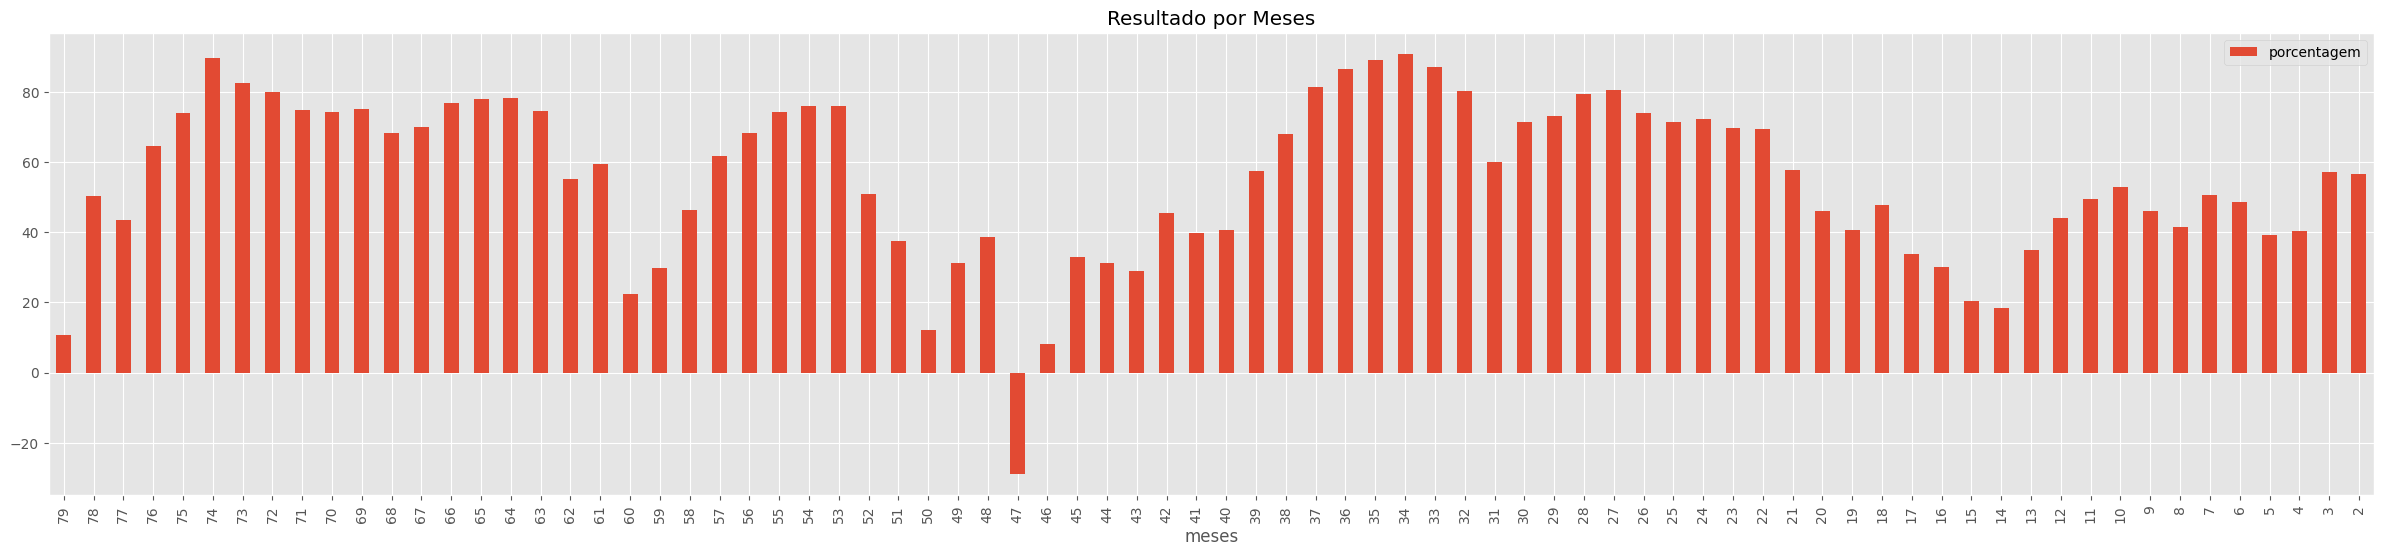

In [17]:
resultados = []
btc_in_dolar = 37833
with open(utils.path + 'results.json', "r") as file:
            resultados = json.load(file)
resultados_filtrados = filter(lambda x: x["corte"] > 1, resultados)
print(resultados_filtrados)
# Crie um DataFrame
df = pd.DataFrame(resultados_filtrados)
df = df.sort_values(by='meses', ascending=False)

# Análise Exploratória de Dados
#print(df.describe())

# Visualizações
df.plot(x='meses', y='porcentagem', kind='bar', title='Resultado por Meses', figsize=(30, 6))
plt.savefig(utils.path + 'resultado.png')

plt.show()
send_email.send_email()